In [1]:
from create_datasets import read_json_dataset
from dict_utils import unfold_to_list, fold_from_list
from pipeline import Pipeline, FewShotPipeline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


def add_lerc_preds(data, lerc_preds_dir, split):
    lerc_preds = read_json_dataset(lerc_preds_dir, split)
        
    for dataset, d in lerc_preds.items():
        for example_id, score in d.items():
            data[dataset][example_id]["LERC"] = (score["pred_score"] - 1) / (5-1)
            
    return data

In [2]:
DATASET_DIR = "../data/lr_experiments"
LERC_PREDS_DIR = f"{DATASET_DIR}/lerc_preds"

train = read_json_dataset(DATASET_DIR, "train_metrics")
dev = read_json_dataset(DATASET_DIR, "dev_metrics")
test = read_json_dataset(DATASET_DIR, "test_metrics")
print(len(train), len(dev), len(test))

add_lerc_preds(dev, LERC_PREDS_DIR, "dev")
add_lerc_preds(test, LERC_PREDS_DIR, "test")

train_df = pd.DataFrame(unfold_to_list(train, "dataset", "example_id"))
dev_df   = pd.DataFrame(unfold_to_list(dev, "dataset", "example_id"))
test_df  = pd.DataFrame(unfold_to_list(test, "dataset", "example_id"))
print(train_df.shape, dev_df.shape, test_df.shape)

train_df["score_scaled"] = train_df.score.apply(lambda s: (s-1)/(5-1))
dev_df["score_scaled"] = dev_df.score.apply(lambda s: (s-1)/(5-1))
test_df["score_scaled"] = test_df.score.apply(lambda s: (s-1)/(5-1))

6 6 6
(31069, 48) (4009, 49) (6321, 49)


In [3]:
DATASETS = list(train.keys())

METRICS = [
    # Bleu
    'bleu1', 'bleu2', 'bleu3', 'bleu4', 
    # 'hf_bleu1', 'hf_bleu2', 'hf_bleu3', 'hf_bleu4', 
    'rougeL', 
    # 'hf_rougeL', 'hf_rougeLsum',
    'hf_rouge1', 'hf_rouge2',
    'meteor',
    'recall', 'precision', 'f1_score',
    'sari_context', 'sari_question',
    # Token overlap when 1st error occurred
    'precision_at_err1', 'recall_at_err1',
    # Confusion matrix
    'tp', 'fn', 'fp',
    # Edit scores ------
    'char_edit_score', 'word_edit_score',
    # Learned metrics -------
    'bertscore', 'bleurt',
    # Input statistics ------
    'candidatelength_word', 'candidatelength_char',
    'candidatenunique_words', 'referencelength_word',
    'referencelength_char', 'referencenunique_words',
    'contextlength_word', 'contextlength_char',
    'contextnunique_words', 'questionlength_word',
    'questionlength_char', 'questionnunique_words',
]

TARGET = "score_scaled"

**Validate numbers reported in original MOCHA paper**

Most of the values are close to the numbers reported in the paper. The ones that are not, are consistently higher.

In [4]:
from scipy.stats import pearsonr

for dataset in DATASETS:
    print(); print("---- DEV SET ----")
    _df = dev_df[dev_df.dataset == dataset]
    print(dataset, "bleu1", round(pearsonr(_df["score_scaled"], _df["bleu1"])[0], 3))
    print(dataset, "meteor", round(pearsonr(_df["score_scaled"], _df["meteor"])[0], 3))
    print(dataset, "rougeL", round(pearsonr(_df["score_scaled"], _df["rougeL"])[0], 3))
    print(dataset, "bert-score", round(pearsonr(_df["score_scaled"], _df["bertscore"])[0], 3))
    print()
    
    print("TEST SET")
    _df = test_df[test_df.dataset == dataset]
    print(dataset, "bleu1", round(pearsonr(_df["score_scaled"], _df["bleu1"])[0], 3))
    print(dataset, "meteor", round(pearsonr(_df["score_scaled"], _df["meteor"])[0], 3))
    print(dataset, "rougeL", round(pearsonr(_df["score_scaled"], _df["rougeL"])[0], 3))
    print(dataset, "bert-score", round(pearsonr(_df["score_scaled"], _df["bertscore"])[0], 3))
    print()


---- DEV SET ----
cosmosqa bleu1 0.66
cosmosqa meteor 0.697
cosmosqa rougeL 0.702
cosmosqa bert-score 0.805

TEST SET
cosmosqa bleu1 0.671
cosmosqa meteor 0.712
cosmosqa rougeL 0.701
cosmosqa bert-score 0.78


---- DEV SET ----
drop bleu1 0.409
drop meteor 0.664
drop rougeL 0.48
drop bert-score 0.174

TEST SET
drop bleu1 0.388
drop meteor 0.568
drop rougeL 0.366
drop bert-score 0.329


---- DEV SET ----
mcscript bleu1 0.182
mcscript meteor 0.461
mcscript rougeL 0.225
mcscript bert-score 0.173

TEST SET
mcscript bleu1 0.261
mcscript meteor 0.503
mcscript rougeL 0.297
mcscript bert-score 0.195


---- DEV SET ----
narrativeqa bleu1 0.403
narrativeqa meteor 0.606
narrativeqa rougeL 0.434
narrativeqa bert-score 0.419

TEST SET
narrativeqa bleu1 0.472
narrativeqa meteor 0.616
narrativeqa rougeL 0.496
narrativeqa bert-score 0.535


---- DEV SET ----
quoref bleu1 0.675
quoref meteor 0.729
quoref rougeL 0.713
quoref bert-score 0.208

TEST SET
quoref bleu1 0.578
quoref meteor 0.716
quoref rouge

In [5]:
def get_subset(df, dataset = None, col="dataset"):
    return df[df[col] == dataset].copy() if dataset else df
    
def get_all_datasets(df, datasets, include_all=True):
    result = {} if not include_all else {"all": df.copy()}
    
    for dataset in datasets:
        result.update({dataset: get_subset(df, dataset)})
        
    return result

def get_loov_datasets(df, datasets):
    result = {}

    for dataset in datasets:
        loo_datasets = [get_subset(df, d) for d in datasets if d != dataset]
        loo_dataset = pd.concat(loo_datasets)
        
        result.update({f"except_{dataset}": loo_dataset})
        
    return result

TRAIN_DATASETS = get_all_datasets(train_df, DATASETS)
DEV_DATASETS   = get_all_datasets(dev_df, DATASETS)
TEST_DATASETS  = get_all_datasets(test_df, DATASETS)

TRAIN_LOO_DATASETS = get_loov_datasets(train_df, DATASETS)

# For baselines and individual metrics (and to avoid duplicating code)
# we may be interested in using "LERC" as a feature (e.g., baseline)
# To re-use the pipeline code, we will create a dummy variable with 
# LERC values of -1 for the dataset.
import copy
TRAIN_DATASETS_DUMMY_LERC = copy.deepcopy(TRAIN_DATASETS)

for dataset in TRAIN_DATASETS_DUMMY_LERC.values(): 
    dataset["LERC"] = -1
    
# Finally, we do a sanity check to ensure the original training set was
# not modified:
assert any("LERC" in d.columns for d in TRAIN_DATASETS.values()) == False

## Clustering

In [47]:
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(14,10)})

In [7]:
# sns.pairplot(dev_df[METRICS +[TARGET]].head(10))

### UMAP 


[UMAP vs T-SNE comparison](https://blog.bioturing.com/2022/01/14/umap-vs-t-sne-single-cell-rna-seq-data-visualization/#:~:text=t%2DSNE%20and%20UMAP%20have,UMAP%20compresses%20that%20graph)
https://umap-learn.readthedocs.io/en/latest/basic_usage.html

In [13]:
from sklearn.preprocessing import StandardScaler
import umap
reducer = umap.UMAP()

In [14]:
dev_df_scaled = dev_df.copy()
dev_df_scaled[METRICS] = StandardScaler().fit_transform(dev_df_scaled[METRICS])
dev_df_scaled.head(2)

,candidate,context,metadata,question,reference,score,bleu1,bleu2,bleu3,bleu4,...,contextlength_word,contextlength_char,contextnunique_words,questionlength_word,questionlength_char,questionnunique_words,LERC,dataset,example_id,score_scaled
0,I want to help Luke feed.,There is one area I want to work on . Breast -...,"{'scores': [1, 1, 1], 'source': 'gpt2'}",What may be your reason for wanting to work on...,It could help my son .,1.0,-0.124228,-0.469178,-0.293406,-0.198862,...,-0.901585,-0.923873,-0.766104,1.462999,1.098332,1.785058,0.196329,cosmosqa,00484c61d760781cc315e45da887e138,0.00
1,the Olympics are watching,The strangest thing that has happened was when...,"{'scores': [2, 2, 2], 'source': 'backtranslati...",What is probably true about this story ?,They are watching the Olympics,2.0,2.501815,2.816834,-0.293369,-0.198862,...,-0.570860,-0.610544,-0.488960,-0.340187,-0.164533,-0.297582,0.987216,cosmosqa,008fcce00cb5455d4449b29e516bafdc,0.25


(4009, 2)


Text(0.5, 1.0, 'UMAP projection of the Metrics dataset')

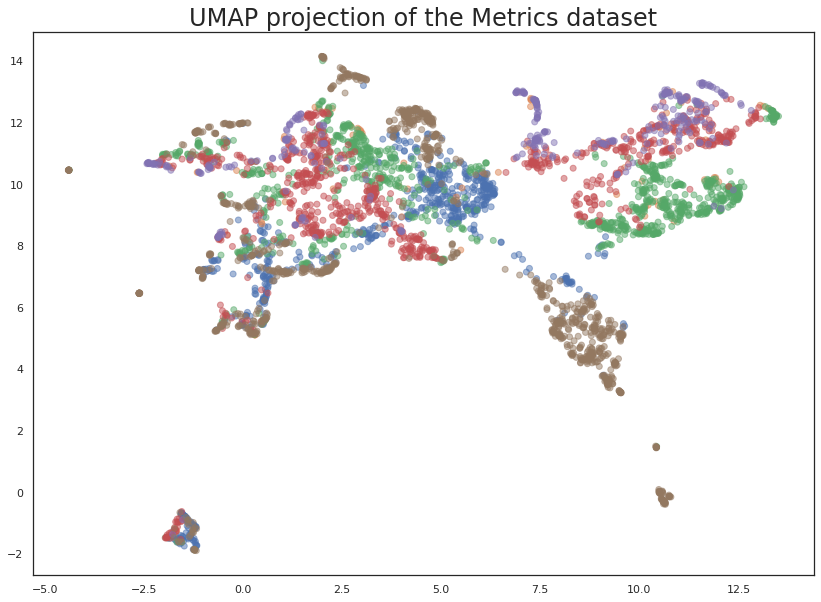

In [19]:
embedding = reducer.fit_transform(dev_df_scaled[METRICS])
print(embedding.shape)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in dev_df_scaled.dataset.map({d: i for i, d in enumerate(DATASETS)})],
    alpha=0.5,
)
# plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Metrics dataset', fontsize=24)

## Results analysis

In [45]:
LERC_LOO_DEV = {
    "narrativeqa": 0.772,
    "mcscript": 0.666,
    "cosmosqa": 0.852,
    "socialiqa": 0.777,
    "drop": 0.760,
    "quoref": 0.704
}

LERC_AD_DEV = {
    "narrativeqa": 0.805,
    "mcscript": 0.816,
    "cosmosqa": 0.864,
    "socialiqa": 0.820,
    "drop": 0.796,
    "quoref": 0.794
}

LERC_LOO_TEST = {
    "narrativeqa": 0.738,
    "mcscript": 0.694,
    "cosmosqa": 0.824,
    "socialiqa": 0.760,
    "drop": 0.712,
    "quoref": 0.741
}

def get_evaluated_on(data, dataset):
    return data[data["evaluated_on"] == dataset]

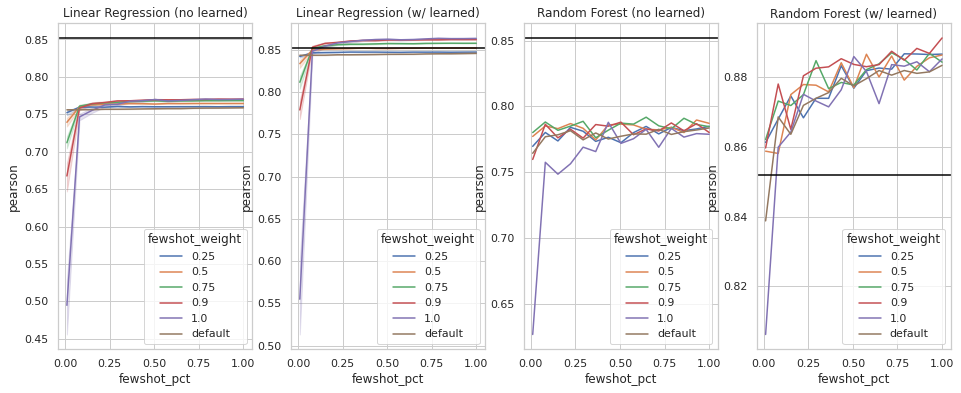

In [54]:
dataset = "cosmosqa"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}

read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_cosmosqa_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_cosmosqa_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_cosmosqa_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_cosmosqa_rfw_learned_metrics_1.csv", **read_csv_kwargs)


fig, axes = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


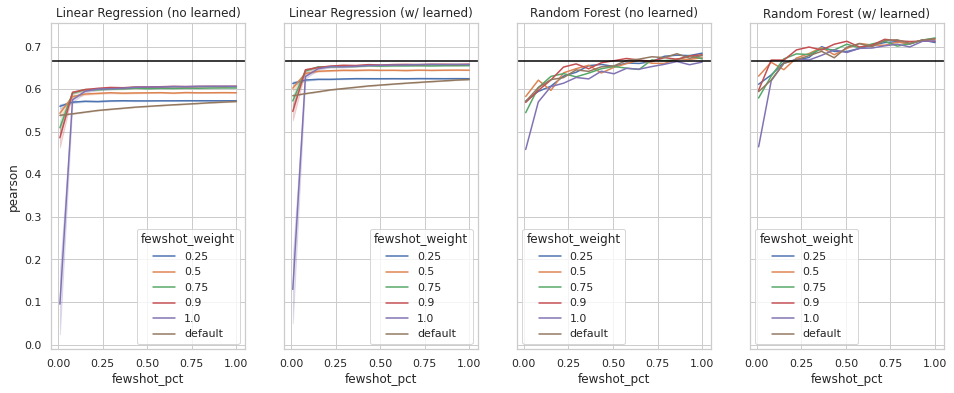

In [55]:
dataset = "mcscript"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}

read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rfw_learned_metrics_1.csv", **read_csv_kwargs)


fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


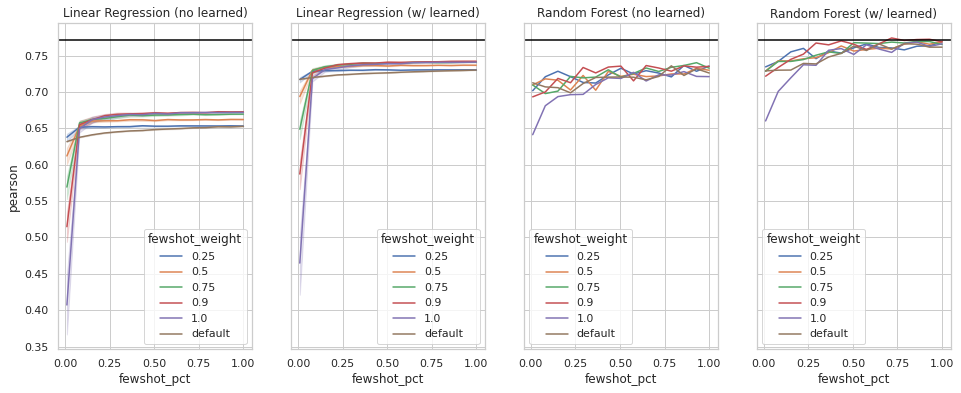

In [56]:
dataset = "narrativeqa"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}

read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rfw_learned_metrics_1.csv", **read_csv_kwargs)

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


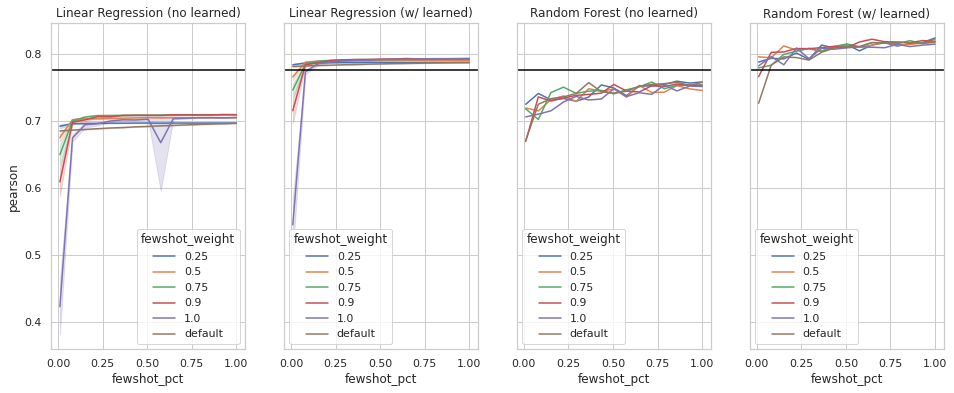

In [57]:
dataset = "socialiqa"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}


read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rfw_learned_metrics_1.csv", **read_csv_kwargs)

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


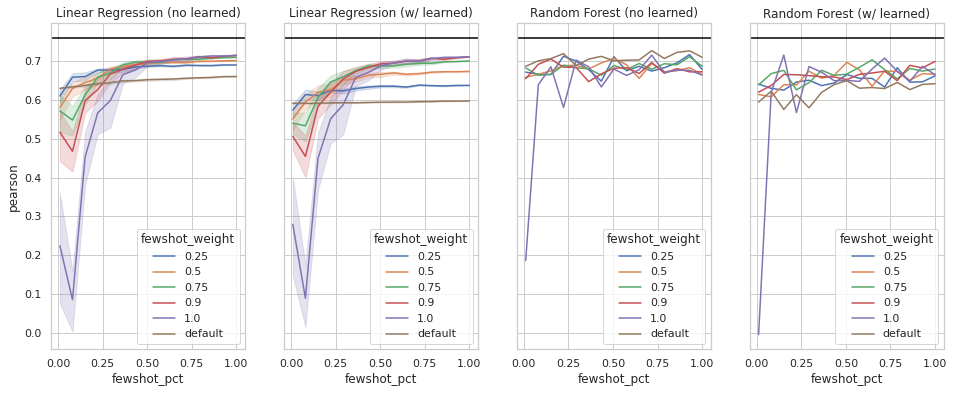

In [58]:
dataset = "drop"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}

read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rfw_learned_metrics_1.csv", **read_csv_kwargs)

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


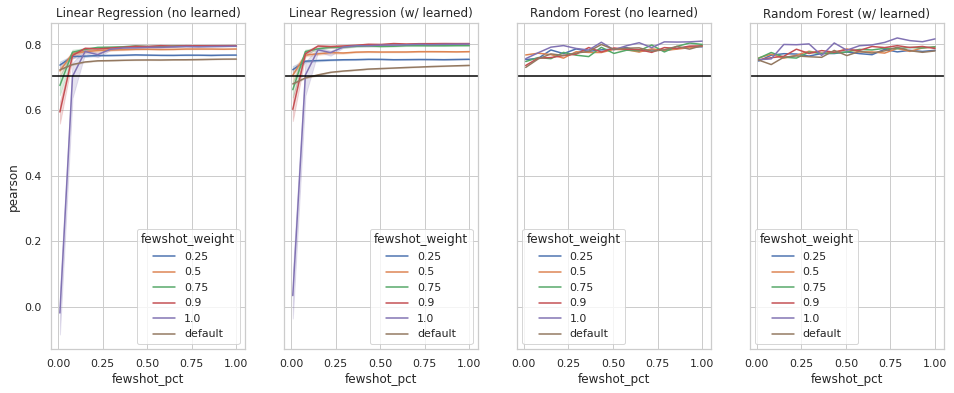

In [59]:
dataset = "quoref"
metric = "pearson"
x_axis = "fewshot_pct"
hst_kwargs = {"hue": "fewshot_weight"}

read_csv_kwargs = {"index_col": 0}
loo_lr_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrno_learned_metrics_20.csv", **read_csv_kwargs)
loo_lr_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_lrw_learned_metrics_20.csv", **read_csv_kwargs)

loo_rf_no_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rf_no_learned_metrics_1.csv", **read_csv_kwargs)
loo_rf_w_learned_results = pd.read_csv(f"results/fewshot_loo_{dataset}_rfw_learned_metrics_1.csv", **read_csv_kwargs)


fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 6))
ax = axes[0]
ax.set_title("Linear Regression (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[1]
ax.set_title("Linear Regression (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_lr_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[2]
ax.set_title("Random Forest (no learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_no_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")

ax = axes[3]
ax.set_title("Random Forest (w/ learned)")
sns.lineplot(ax=ax, data=get_evaluated_on(loo_rf_w_learned_results, dataset), x=x_axis, y=metric, **hst_kwargs)
ax.axhline(LERC_LOO_DEV[dataset], color="black", label="LERC (LOO)")


In [ ]:
# Lasso